#**KaggleX Skill Assessment Challenge**

**Autor: Karen Sarai Morales Montiel**


**Fecha: 29/07/2024**

Kaggle es una plataforma de competición de ciencia de datos para cientificios de datos y entusiastas de machine learning bajo Google LLC. Desde 2020 abren convocatorios de mentoría para principiantes donde los participantes deben de completar un reto para enviar su petición de entrada; este año el reto fue el desarrollo de un modelo de predicción del costo de coches usados.

El dataset usado para el proyecto contiene 11 campos:



*   **id** : id del vehículo
*   **brand** : marca de vehículo
*   **model** : model del vehículo
*   **model_year** : año de ensamblaje de vehículo
*   **milage** : millas del vehículo
*   **fuel_type** : tipo de combustible que usa el vehículo
*   **engine** : especificaciones del motor
*   **ext_col** : color exterior del vehículo
*   **int_col** : color interior del vehículo
*   **clean_title** : si esta disponible
*   **price** : precio del vehículo




In [ ]:
import pandas as pd

url = 'https://raw.githubusercontent.com/KarenSaraiMoralesMontiel/machine_learning_project/main/data/cars_train.csv'
train_used_cars_df = pd.read_csv(url,index_col=0)

##División de datos

In [ ]:
X = train_used_cars_df[train_used_cars_df.columns[:-1]]
y = train_used_cars_df[train_used_cars_df.columns[-1]]

Dividimos los datos en datos de entrenamiento (60%), validación (20%) y de testeo (20%)

In [ ]:
from sklearn.model_selection import train_test_split

def splitting_data(X , y):
  X_train, X_test , y_train, y_test = train_test_split(X , y , test_size=.2 , random_state = 42)
  X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=.25 , random_state=42)
  return X_train, X_val,  X_test, y_train , y_val, y_test

In [ ]:
X_speed_train , X_speed_val, X_speed_test , y_speed_train , y_speed_val , y_speed_test = splitting_data(X, y)

In [ ]:
result_df = train_used_cars_df.copy()

##Extracción de valores

Antes de hacer la exploración de datos necesitamos extraer valores del campo engine y disminuir las variedades de campos como color y transmission (la imputación y normalización va después del EDA). Vamos a definir las funciones para ponerlas en una función de limpieza para aplicarlo en cada uno de las divisiones.

In [ ]:
def group_colors(color):
    """
  Definimos la agrupación de colores y la aplicamos en los datos
  """
    color = color.lower()
    color_groups = {
        'Black': ['black', 'jet', 'charcoal'],
        'White': ['white', 'pearl', 'ivory'],
        'Red': ['red', 'maroon', 'burgundy'],
        'Blue': ['blue', 'navy', 'azure', 'cyan'],
        'Green': ['green', 'olive', 'lime'],
        'Yellow': ['yellow', 'gold', 'beige', 'sand'],
        'Grey': ['grey', 'gray', 'silver', 'metallic'],
        'Brown': ['brown', 'tan', 'chocolate'],
        'Other': []
    }

    for main_color, sub_colors in color_groups.items():
        if any(sub_color in color for sub_color in sub_colors):
            return main_color
    return 'Other'

El campo engine contiene las especificaciones del motor como el HP (Horse Power), L (volumen del motor) , número de cilindros y el tipo de cilindros que ocupa. Para extraerlos usamos la librería re para usar expresiones regulares y extraerlo.

In [ ]:
import re
def parse_engine(engine_str):
    # Regular expressions for extracting the details
    hp_pattern = r'(\d+\.?\d*)HP'
    volume_pattern = r'(\d+\.?\d*)L'
    #volume_pattern2 = r'(\d+\.?\d*) Liter'
    cylinders_acronym_pattern = r'(V|I|H)(\d+)'
    type_pattern = r'(V|Straight|I|H)?\s*(\d+)\s*Cylinders?'

    # Extracting the horsepower
    hp = re.search(hp_pattern, engine_str)
    hp = float(hp.group(1)) if hp else None

    if 'electric motor' in engine_str.lower() or 'electric fuel' in engine_str.lower():
        return hp, 0, 0, 'Electric', 0


    # Extracting the volume
    volume = re.search(volume_pattern, engine_str)
    volume = str(volume.group(1)) if volume else None


    # Extracting the number and type of cylinders
    cylinders_match = re.search(cylinders_acronym_pattern, engine_str)
    if cylinders_match:
        cylinder_type = 'V' if cylinders_match.group(1) == 'V' else 'Inline'
        cylinders = int(cylinders_match.group(2))
        if cylinders_match.group(1) == 'H':
                cylinder_type = 'Straight'
    else:
        cylinders_match = re.search(type_pattern, engine_str)
        if cylinders_match:
            cylinder_type = cylinders_match.group(1) if cylinders_match.group(1) else ''
            cylinders = str(cylinders_match.group(2))
            cylinder_type = cylinder_type or ('V' if 'V' in engine_str else 'Straight' if 'Straight' in engine_str else 'Inline')
        else:
            cylinders = None
            cylinder_type = None

    turbo = 'Y' if 'Turbo' in engine_str or 'turbo' in engine_str else 'N'

    return hp, volume, cylinders, cylinder_type, turbo

También hay que definir una función que corrija el tipo de motor

In [ ]:
def correct_fuel_type(row):
    if 'Tesla' in row['brand'] or 'electric motor' in row['engine'].lower():
        return 'Electric'
    return row['fuel_type']

Una función para extraer los valores de transmission y categorizarla

In [ ]:
def get_transmission_speed(transmission_str):
    # Search for the pattern of digits followed by "HP"
    t_match = re.search(r'(\d+\.\d+|\d+)-Speed', transmission_str)

    if t_match:
        # Extract the number part of the match
        t = str(t_match.group(1))
        # Remove the "HP" part from the string
        modified_str = transmission_str.replace(t_match.group(0), '').strip()
        return pd.Series([t, modified_str])
    else:
        # Return NaN and the original string if no match is found
        return pd.Series([0, transmission_str])

def categorize_transmission(transmission_str):
    transmission_str = transmission_str.lower()
    if 'manual' in transmission_str or 'm/t' in transmission_str:
        return 'Manual'
    elif 'dual' in transmission_str or 'dual shift' in transmission_str:
        return 'Dual Shift'
    elif 'cvt' in transmission_str:
        return 'CVT'
    else:
        return 'Auto'

Una para conseguir la edad

In [ ]:
import datetime

def get_age(model_year):
  return datetime.datetime.now().year  - model_year

Funciones para guardar datos en formato pickle

In [ ]:
import pickle
def save(file_path, result):

  file_path = file_path + '.pickle'

# Open the file in binary mode
  with open(file_path, 'wb') as file:
    # Serialize and write the variable to the file
    pickle.dump(result, file)


def read(file_path):

# Open the file in binary mode
  with open(file_path, 'rb') as file:
    # Serialize and write the variable to the file
    return pickle.load(file_path)

Y la función que usa todo para la limpieza de datos

In [ ]:
def clean_data_speed(train_used_cars_df):
  train_used_cars_df.loc[:,'accident'] = train_used_cars_df['accident'].replace({'None reported': 0, "At least 1 accident or damage reported": 1})
  train_used_cars_df.loc[:,'transmission'] = train_used_cars_df['transmission'].replace({'6 Speed At/Mt' : '6-Speed At/Mt', '6 Speed Mt' : '6-Speed Mt'})
  train_used_cars_df['model_age'] = train_used_cars_df['model_year'].apply(get_age)
  #train_used_cars_df['ext_col'] = train_used_cars_df['ext_col'].apply(group_colors)
  #train_used_cars_df['int_col'] = train_used_cars_df['int_col'].apply(group_colors)
  train_used_cars_df[['HP', 'L', 'cylinders', 'cylinder_type','turbo']] = train_used_cars_df['engine'].apply(parse_engine).apply(pd.Series)
  train_used_cars_df[['transmission_speed' , 'transmission']] = train_used_cars_df['transmission'].apply(get_transmission_speed)
  train_used_cars_df['transmission'] = train_used_cars_df['transmission'].apply(categorize_transmission)
  train_used_cars_df.loc[:,'int_col'] = train_used_cars_df['int_col'].apply(group_colors)
  train_used_cars_df.loc[:,'ext_col'] = train_used_cars_df['ext_col'].apply(group_colors)
  return train_used_cars_df

Limpiamos los datos

In [ ]:
X_speed_train = clean_data_speed(X_speed_train)
X_speed_test = clean_data_speed(X_speed_test)
X_speed_val = clean_data_speed(X_speed_val)

In [ ]:
result_df = clean_data_speed(result_df)

##Exploratory Data Analysis

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

Checamos la correlación entre los valores númericos y el precio

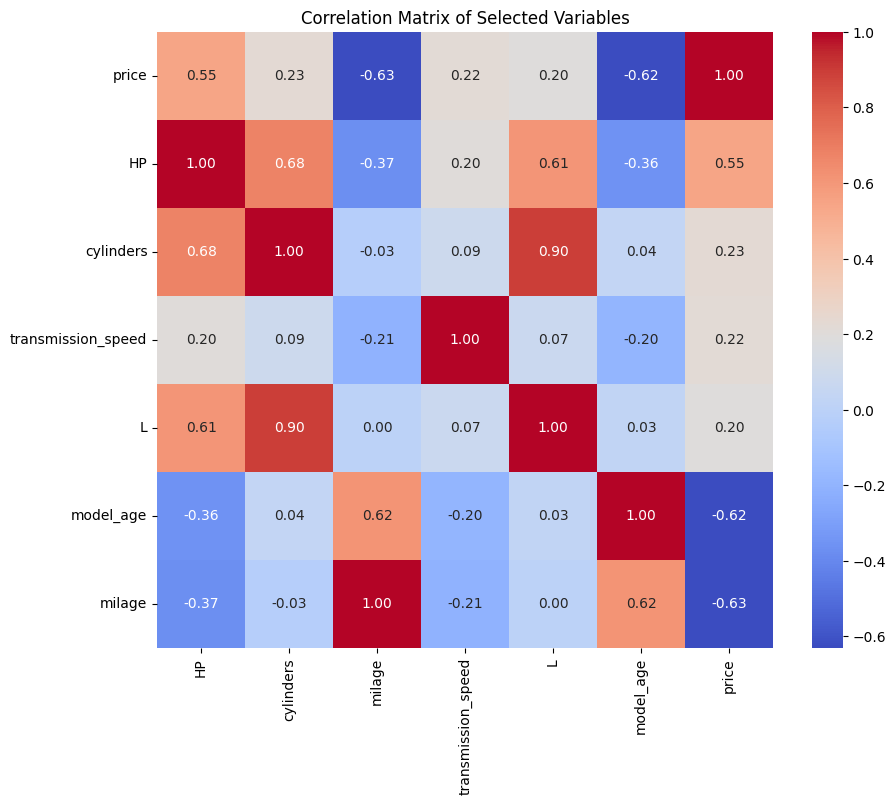

<Figure size 640x480 with 0 Axes>

In [ ]:
# Calculate the correlation matrix
selected_columns = [ 'HP', 'cylinders' , 'milage' ,'transmission_speed' ,'L','model_age' , 'price']
non_null = result_df[selected_columns].dropna()

# Compute the correlation matrix
corr_matrix = non_null.corr().sort_values('price', ascending=False)

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, square=True)
plt.title('Correlation Matrix of Selected Variables')
plt.show()
plt.savefig('Correlation of variables and price')

Se ve que el HP, cylinders, transmission_speed y L son valores que tienen una correlación positiva con el precio - sin embargo también se puede notar que hay una correlación grande entre cylinders y L. Para evitar colinearidad eliminaremos L. Checamos los diagramas de cajas de variables categóricas.

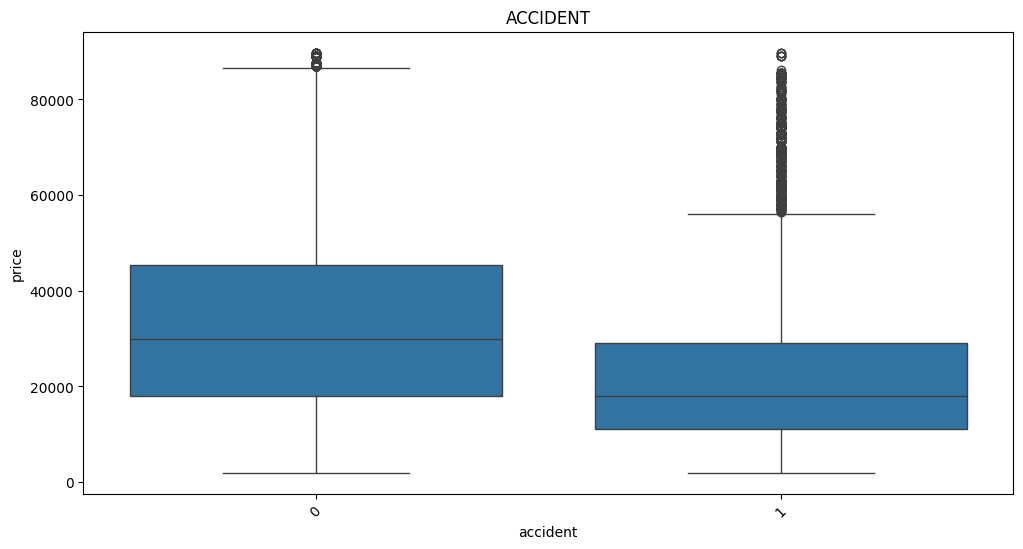

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='accident', y='price', data=result_df)
plt.title('ACCIDENT')
plt.xticks(rotation=45)
plt.show()

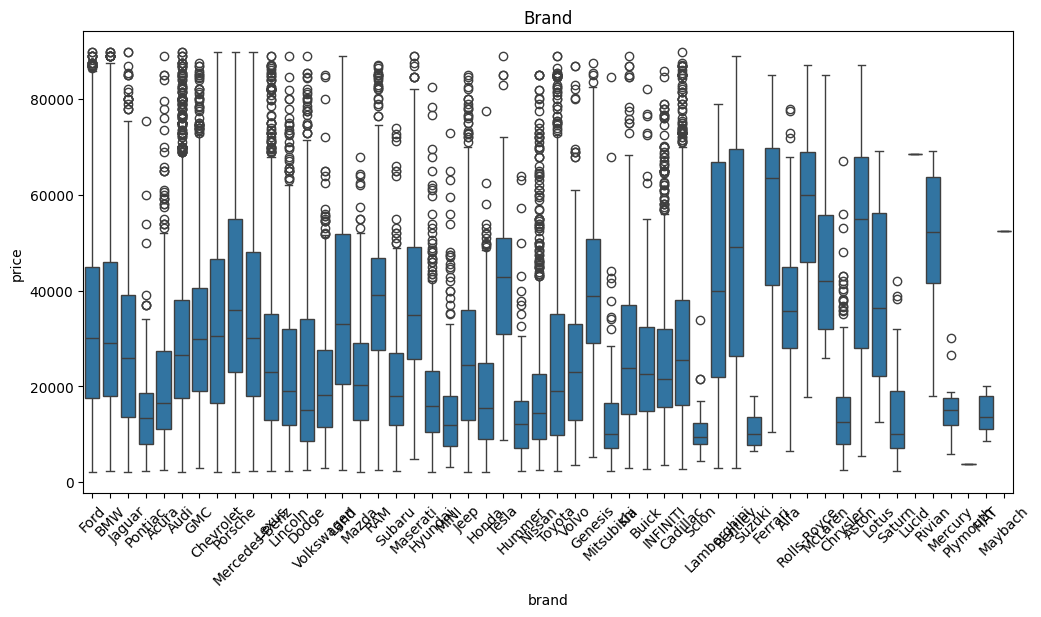

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='brand', y='price', data=result_df)
plt.title('Brand')
plt.xticks(rotation=45)
plt.show()

Pese se ve una variación entre los valores de marca no se va a usar el campo 'brand' en el modelo porque se usar para la imputación de los datos HP, cylinder_type y turbo.




In [ ]:
import statsmodels.regression.linear_model as sm
model_anova = sm.OLS.from_formula('HP ~  C(brand) + C(model_year) + C(model)', data=result_df)
result_anova = model_anova.fit()
print(result_anova.summary())

                            OLS Regression Results                            
Dep. Variable:                     HP   R-squared:                       0.954
Model:                            OLS   Adj. R-squared:                  0.952
Method:                 Least Squares   F-statistic:                     523.9
Date:                Wed, 31 Jul 2024   Prob (F-statistic):               0.00
Time:                        02:44:50   Log-Likelihood:            -2.1057e+05
No. Observations:               46626   AIC:                         4.247e+05
Df Residuals:                   44840   BIC:                         4.403e+05
Df Model:                        1785                                         
Covariance Type:            nonrobust                                         
                                                                          coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------

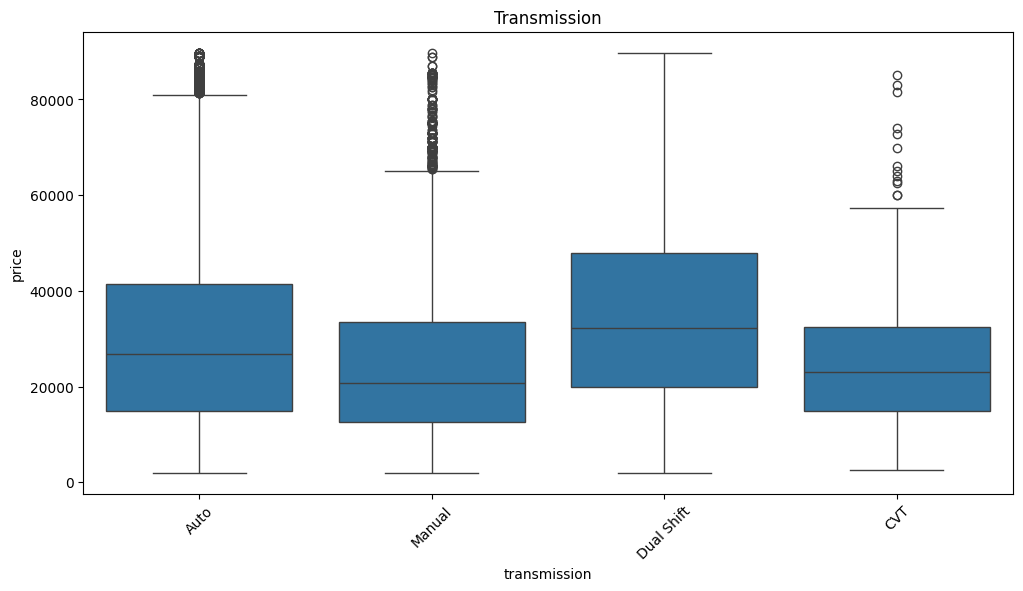

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='transmission', y='price', data=result_df)
plt.title('Transmission')
plt.xticks(rotation=45)
plt.show()

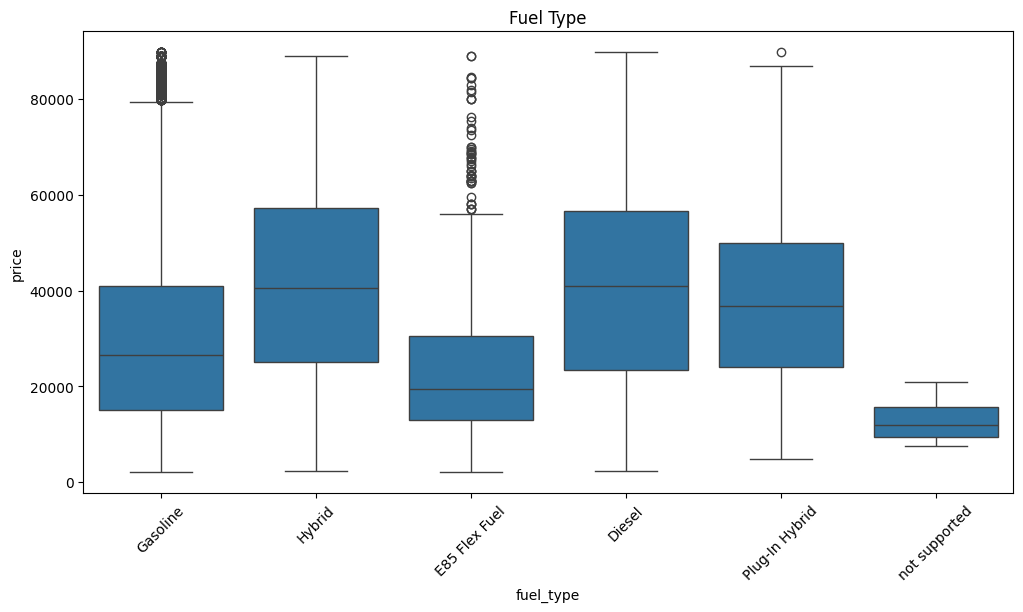

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='fuel_type', y='price', data=result_df)
plt.title('Fuel Type')
plt.xticks(rotation=45)
plt.show()

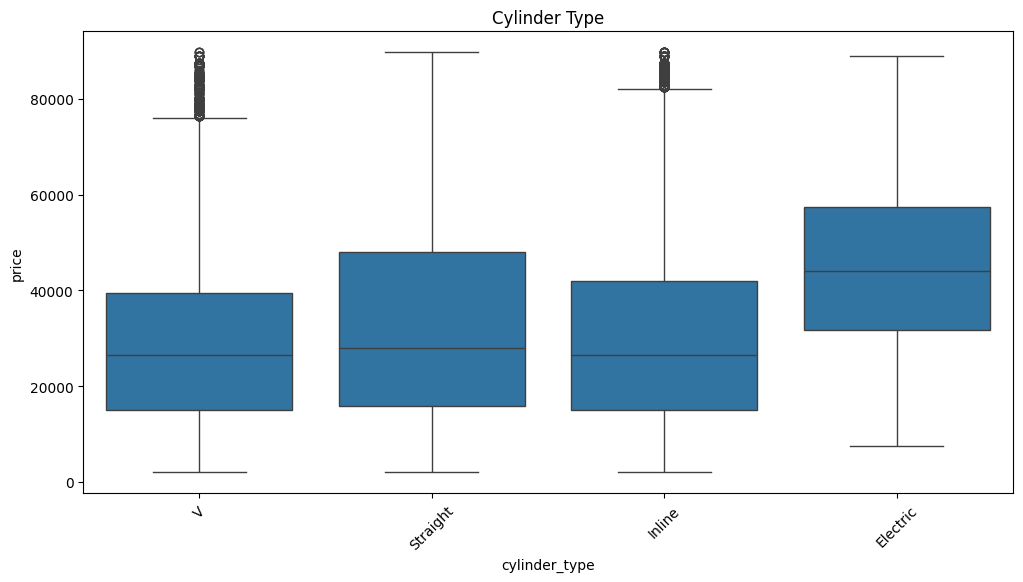

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='cylinder_type', y='price', data=result_df)
plt.title('Cylinder Type')
plt.xticks(rotation=45)
plt.show()

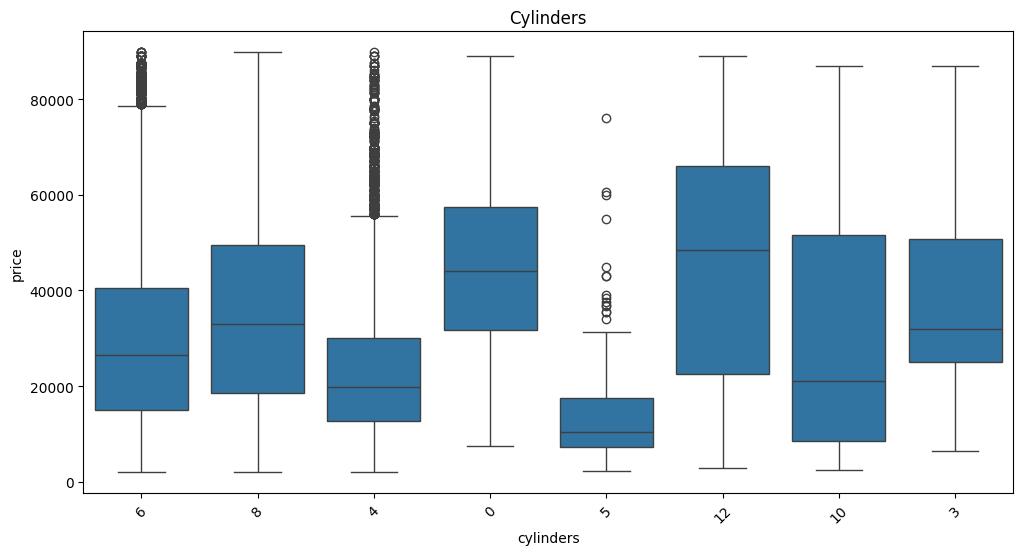

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='cylinders', y='price', data=result_df)
plt.title('Cylinders')
plt.xticks(rotation=45)
plt.show()

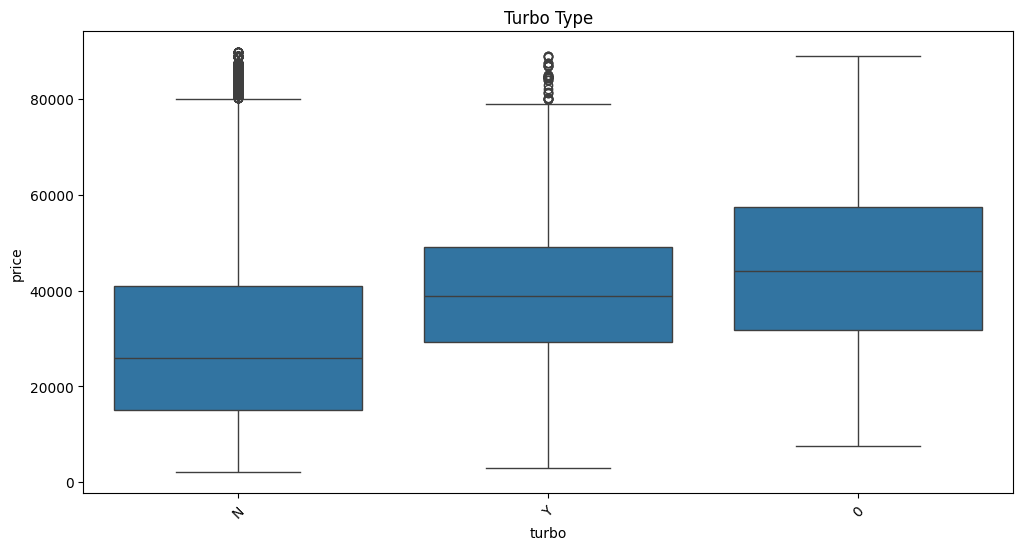

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='turbo', y='price', data=result_df)
plt.title('Turbo Type')
plt.xticks(rotation=45)
plt.show()

Haces un T-test para checar si accident es significante

In [ ]:
from scipy.stats import ttest_ind
# Separate the data into two groups
price_no_accident = result_df[result_df['accident'] == 0]['price'].dropna()
price_accident = result_df[result_df['accident'] == 1]['price'].dropna()

# Perform t-test
t_stat, p_value = ttest_ind(price_no_accident, price_accident)

print(f'T-statistic: {t_stat:.4f}, P-value: {p_value:.4f}')

# Interpret the result
alpha = 0.05
if p_value < alpha:
    print("There is a significant difference in prices based on accident status.")
else:
    print("There is no significant difference in prices based on accident status.")


T-statistic: 60.3275, P-value: 0.0000
There is a significant difference in prices based on accident status.


##Imputing data and normalizing

Hacemos imputaciones de los valores HP, cilindros y tipo de cilindros

In [ ]:
from sklearn.preprocessing import StandardScaler
import numpy as np

def imputing_data(df):
   # Apply the function to fill missing HP values
   # Apply the function to fill missing HP values
    df = fill_missing_hp(df)
    df = fill_missing_val(df, 'cylinders')
    df = fill_missing_val(df, 'cylinder_type')


    df['HP'] = pd.to_numeric(df['HP'], errors='coerce')

    # Correct the fuel type for Tesla
    df['fuel_type'] = df.apply(correct_fuel_type, axis=1)

    cleanerdf = df.drop(columns=['id', 'clean_title' ,'brand' , 'L',  'engine', 'model_year' ,'model_age' , 'ext_col' , 'int_col' , 'model' , 'milage'
    ], inplace=False)
    df_cleaned = cleanerdf.dropna()
    return df_cleaned

def fill_missing_hp(df):
    df['HP'] = df.groupby(['model', 'brand', 'model_year'])['HP'].transform(
        lambda x: x.fillna(x.mean())
    )

    def get_closest_year_hp(row, df):
        model, brand, year = row['model'], row['brand'], row['model_year']
        mask = (df['model'] == model) & (df['brand'] == brand)
        available_years = df[mask & df['HP'].notna()]['model_year'].unique()

        if available_years.size == 0:
            return df['HP'].mode()[0]  # Use mode of all HPs if no match is found

        closest_year = available_years[np.abs(available_years - year).argmin()]
        closest_year_hp = df[mask & (df['model_year'] == closest_year)]['HP'].mean()

        return closest_year_hp

    df['HP'] = df.apply(
        lambda row: get_closest_year_hp(row, df) if pd.isnull(row['HP']) else row['HP'], axis=1
    )

    return df

def fill_missing_val(df, col):

    df[col] = df.groupby(['model', 'brand', 'model_year'])[col].transform(
        lambda x: x.fillna(x.mode()[0] if not x.mode().empty else np.nan)
    )

    def get_closest_year_val(row, df, col):
        model, brand, year = row['model'], row['brand'], row['model_year']
        mask = (df['model'] == model) & (df['brand'] == brand)
        available_years = df[mask & df[col].notna()]['model_year'].unique()

        if available_years.size == 0:
            return df[col].mode()[0]  # Use mode of all HPs if no match is found

        closest_year = available_years[np.abs(available_years - year).argmin()]
        closest_year_val = df[mask & (df['model_year'] == closest_year)][col].mode()
        if closest_year_val.empty:
            return df[col].mode()[0]

        return closest_year_val[0]

    df[col] = df.apply(
        lambda row: get_closest_year_val(row, df, col) if pd.isnull(row[col]) else row[col], axis=1
    )

    return df

Normalizamos los datos para entrenarlos

In [ ]:

def normalizing_data(X_entry):
  X = X_entry.copy()
  categorical_features = [
      'fuel_type' ,

                          'cylinder_type' ,
                          'accident' ,
                          'transmission',
                          'turbo'
                          ]
  numerical_features = ['HP' , 'cylinders' , 'transmission_speed']

  scaler = StandardScaler()
  num_cols = X.drop(categorical_features, axis=1).columns.tolist()

  X[num_cols] = scaler.fit_transform(X[num_cols])

  X = pd.get_dummies(X, columns=categorical_features , dtype=int , drop_first=True)
  return X

Imputamos los datos

In [ ]:
X_speed_train = imputing_data(X_speed_train)
X_speed_val = imputing_data(X_speed_val)
X_speed_test = imputing_data(X_speed_test)

<ipython-input-68-e7a61e5896d3>:49: UserWarning: Unable to sort modes: '<' not supported between instances of 'int' and 'str'
  lambda x: x.fillna(x.mode()[0] if not x.mode().empty else np.nan)
<ipython-input-68-e7a61e5896d3>:49: UserWarning: Unable to sort modes: '<' not supported between instances of 'str' and 'int'
  lambda x: x.fillna(x.mode()[0] if not x.mode().empty else np.nan)
<ipython-input-68-e7a61e5896d3>:49: UserWarning: Unable to sort modes: '<' not supported between instances of 'str' and 'int'
  lambda x: x.fillna(x.mode()[0] if not x.mode().empty else np.nan)
<ipython-input-68-e7a61e5896d3>:49: UserWarning: Unable to sort modes: '<' not supported between instances of 'int' and 'str'
  lambda x: x.fillna(x.mode()[0] if not x.mode().empty else np.nan)
<ipython-input-68-e7a61e5896d3>:49: UserWarning: Unable to sort modes: '<' not supported between instances of 'int' and 'str'
  lambda x: x.fillna(x.mode()[0] if not x.mode().empty else np.nan)
<ipython-input-68-e7a61e5896d3

Normalizamos

In [ ]:
X_speed_train = normalizing_data(X_speed_train)
X_speed_val = normalizing_data(X_speed_val)
X_speed_test = normalizing_data(X_speed_test)


##Building models

Verificamos que las columnas esten ordenadas

In [ ]:

def fit_columns(X_test, X_val, X_train):
  if set(X_train.columns) == set(X_test.columns) == set(X_val.columns):
    return X_train, X_val, X_test
  else:
    all_columns = list(set(list(X_train.columns) + list(X_test.columns) + list(X_val.columns)))
    for c in all_columns:
      if c not in list(X_test.columns):
        X_test[c] = 0
      if c not in list(X_val.columns):
        X_val[c] = 0
      if c not in list(X_test.columns):
        X_test[c] = 0
  return X_test[all_columns], X_val[all_columns], X_train[all_columns]

In [ ]:
X_speed_train, X_speed_val , X_speed_test = fit_columns(X_speed_train, X_speed_val , X_speed_test)

###Machine Learning Clásico

Hacemos Machine Learning Clásico, vamos a comprobar 5 modelos de machine learning clásico y uno ML.



*   RandomForestRegressor
*   DecisionTreeRegressor
*   LinearRegression
*   KNeighbrosRegressor
*   LogisticRegression



In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
import pandas as pd

Establecemos los parametros para identifcar los óptimos

In [ ]:
param_grid_decision_tree = {'clf__criterion' : ['friedman_mse'],
                            'clf__max_depth' : [None],
                            'clf__min_samples_split' : [2,3,5]}
param_grid_random_forest = {
                            'clf__max_depth' : [None,10,20],
                            'clf__min_samples_split': [2,3,5]}
param_grid_log_reg = { 'clf__C' : [0.1,1,10],
                      'clf__penalty' : ['none', 'l2']

}
param_grid_neighbors = { 'clf__n_neighbors' : [5, 10 , 15 , 20],
                        'clf__weights' : ['uniform' , 'distance' , None],
                         'clf__algorithm' : ['auto' , 'ball_tree' , 'kd_tree'],
                         'clf__leaf_size' : [12, 15, 30, 35]
}


Establecemos los parametros, modelos para almacenarlos en un array.

In [ ]:
params = [param_grid_neighbors, param_grid_decision_tree, param_grid_random_forest,
          param_grid_log_reg
          ]
clfs = [('KNeighborsRegressor' , KNeighborsRegressor()), ('DecisionTreeRegressor' , DecisionTreeRegressor()),
        ('RandomForestRegressor', RandomForestRegressor()),
        ('LogisticRegressor', LogisticRegression())
        ]
end_result = []

Entrenamos los modelos (este celda toma 1 hora en cargar)

In [ ]:
import time
for clf, param_grid in zip(clfs, params):

    pl = Pipeline([
        ('clf' , clf[1])
    ])

    # Create the GridSearchCV object
    grid_search = GridSearchCV(estimator=pl, param_grid=param_grid , n_jobs = -1)

    # Fit the GridSearchCV object
    beg = time.time()
    grid_search.fit(X_speed_train, y_speed_train)
    end = time.time()

    final_time = end - beg
    best_params = grid_search.best_params_

    y_pred = grid_search.predict(X_speed_test)
    error = mean_squared_error(y_speed_test, y_pred)
    save(clf[0], grid_search)
    end_result.append((clf[0], final_time, best_params , error))

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Aplicamos Regresion lineal

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import time


In [ ]:
from sklearn.pipeline import Pipeline
final = []

for degree in [1]:
  pl = Pipeline([
      ('poly' , PolynomialFeatures(degree)),
      ('lr' , LinearRegression())
  ])

  beg = time.time()
  pl.fit(X_speed_train, y_speed_train)
  end = time.time()

  y_pred = pl.predict(X_speed_test)
  final_time = end - beg
  error = mean_squared_error(y_speed_test, y_pred)
  save('Linear Regression', pl)
  end_result.append(('Linear Regression', final_time, 1 , error))



###MLP

Definimos función para visualizar el error y la loss en la MLP

In [ ]:
def plot_history(history):
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [MPG]')
    plt.plot(history.epoch, history.history['mse'],
            label='Train Error')
    plt.plot(history.epoch, history.history['val_mse'],
            label = 'Val Error')
    plt.legend()

    plt.savefig('MLP_error_data.png')
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(history.epoch, history.history['loss'],
            label='Train Loss')
    plt.plot(history.epoch, history.history['val_loss'],
            label = 'Val Loss')
    plt.legend()
    plt.savefig('MLP_loss_data.png')

Definimos la red neural como



128 neuronas (activación relu)

16 neuronas (activación relu)

1 neurona (activación None)

In [ ]:
import keras
from keras import layers
import tensorflow as tf

model = keras.Sequential([
layers.Dense(128, activation='relu', input_shape=[X_speed_train.shape[1]]),
layers.Dense(16, activation='relu'),
layers.Dense(1, activation=None)
])

optimizer = tf.keras.optimizers.RMSprop(0.001)

model.compile(loss='mse',
            optimizer=optimizer,
            metrics=['mae', 'mse'])

Definimos un ModelCheckpoint que lo monitorea en base al loss de los valores de validación

In [ ]:
from keras.callbacks import ModelCheckpoint
filepath = 'MLP.keras'
checkpoint_best = ModelCheckpoint(filepath=filepath,
                             monitor='val_loss',
                             save_best_only=True,
                            mode = 'min'
                            )

callbacks = [checkpoint_best]

Entrenamos en 50 epocas

In [ ]:
import time
EPOCHS = 50
beg = time.time()
history = model.fit(
  X_speed_train, y_speed_train,
  epochs=EPOCHS, callbacks = callbacks, validation_data = (X_speed_val, y_speed_val), verbose=1)
end = time.time()
final_time = end - beg

Epoch 1/50
937/937 [==============================] - 4s 3ms/step - loss: 1200852608.0000 - mae: 28833.7637 - mse: 1200852608.0000 - val_loss: 952903488.0000 - val_mae: 24603.2188 - val_mse: 952903488.0000
Epoch 2/50
937/937 [==============================] - 3s 3ms/step - loss: 533904960.0000 - mae: 17220.7148 - mse: 533904960.0000 - val_loss: 306433536.0000 - val_mae: 13609.4141 - val_mse: 306433536.0000
Epoch 3/50
937/937 [==============================] - 2s 2ms/step - loss: 285739520.0000 - mae: 13148.9551 - mse: 285739520.0000 - val_loss: 270215712.0000 - val_mae: 12748.0850 - val_mse: 270215712.0000
Epoch 4/50
937/937 [==============================] - 2s 2ms/step - loss: 257782864.0000 - mae: 12376.1875 - mse: 257782864.0000 - val_loss: 249980720.0000 - val_mae: 12085.0049 - val_mse: 249980720.0000
Epoch 5/50
937/937 [==============================] - 2s 2ms/step - loss: 243125424.0000 - mae: 11925.6641 - mse: 243125424.0000 - val_loss: 241021600.0000 - val_mae: 11853.7686 - va

Visualizamos

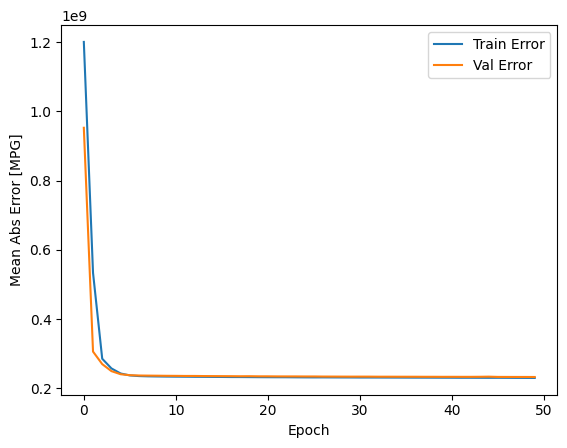

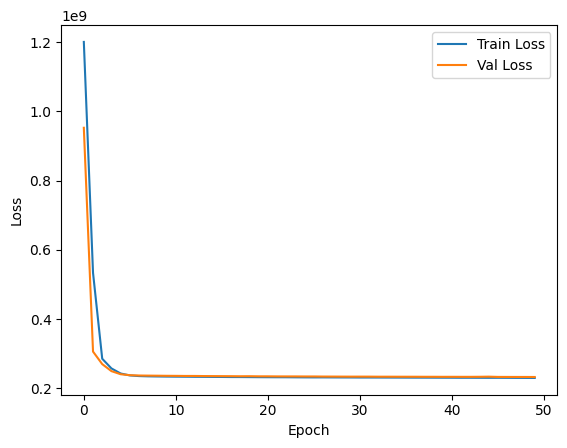

In [ ]:
plot_history(history)

Evaluamos con los valores de testeo

In [ ]:
from sklearn.metrics import mean_squared_error
y_pred = model.predict(X_speed_test)
error = mean_squared_error(y_pred=y_pred, y_true=y_speed_test)

313/313 [==============================] - 0s 1ms/step


Visualizamos el modelo MLP

In [ ]:
!pip install -q visualkeras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.8/993.8 kB 11.7 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/visualkeras/layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


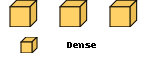

In [ ]:
from visualkeras import layered_view

layered_view(model,
            legend=True,draw_funnel=False,
            draw_volume=True,spacing=30, to_file='MLP_structure.png')

Vemos el resumen del modelo

In [ ]:
pd.to_pickle(model.summary(), 'model_summary.pickle')

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 128)               2432      
                                                                 
 dense_10 (Dense)            (None, 16)                2064      
                                                                 
 dense_11 (Dense)            (None, 1)                 17        
                                                                 
Total params: 4513 (17.63 KB)
Trainable params: 4513 (17.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Lo ponemos en los resultados finales

In [ ]:
end_result.append(('MLP', final_time , model.summary() , error))

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 128)               2432      
                                                                 
 dense_7 (Dense)             (None, 16)                2064      
                                                                 
 dense_8 (Dense)             (None, 1)                 17        
                                                                 
Total params: 4513 (17.63 KB)
Trainable params: 4513 (17.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Lo pasamos a un dataframe para comparar los resultados

In [ ]:
result_df = pd.DataFrame(end_result, columns=['name', 'time (seconds)', 'param' , 'mse error']).sort_values('mse error').reset_index(drop=True)


In [ ]:
result_df.to_csv('results.csv')

In [ ]:
result_df

,name,time (seconds),param,mse error
0,KNeighborsRegressor,957.273622,"{'clf__algorithm': 'ball_tree', 'clf__leaf_siz...",1.983619e+08
1,RandomForestRegressor,139.468629,"{'clf__max_depth': 20, 'clf__min_samples_split...",2.073045e+08
2,MLP,119.181046,NaN,2.261216e+08
3,Linear Regression,0.053219,1,2.269155e+08
4,DecisionTreeRegressor,0.973772,"{'clf__criterion': 'friedman_mse', 'clf__max_d...",2.322974e+08
5,LogisticRegressor,2337.744377,"{'clf__C': 0.1, 'clf__penalty': 'l2'}",3.074145e+08


El modelo que tiene mejor performance es el de KNeighborsRegressor pese a ser el segundo que toma más tiempo